<a href="https://colab.research.google.com/github/Livini-Perera/DeepVision/blob/main/DeepVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print("\nGPU is ready!")
else:
    print("\n⚠️ No GPU! Go to: Runtime → Change runtime type → T4 GPU")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA version: 12.6
GPU: Tesla T4

✅ GPU is ready!


In [ ]:
!pip install ultralytics==8.0.196 -q
print("✅ YOLOv8 installed!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 23.1 MB/s eta 0:00:00
✅ YOLOv8 installed!


In [ ]:
print("Importing libraries...")

import torch
import os
from google.colab import files
import shutil

# ===== PYTORCH FIX - THIS SOLVES THE ERROR =====
_original_torch_load = torch.load

def _fixed_torch_load(*args, **kwargs):
    kwargs['weights_only'] = False
    return _original_torch_load(*args, **kwargs)

torch.load = _fixed_torch_load
print("✅ PyTorch compatibility fix applied")

# Import YOLO
from ultralytics import YOLO

print("✅ All libraries imported!")
print(f"PyTorch: {torch.__version__}")
print(f"GPU: {torch.cuda.is_available()}")

Importing libraries...
✅ PyTorch compatibility fix applied
✅ All libraries imported!
PyTorch: 2.9.0+cu126
GPU: True


In [ ]:
print("Upload your dataset ZIP file")
print("(Make sure it's named vehicle-dataset.zip)")

uploaded = files.upload()

zip_file = list(uploaded.keys())[0]
print(f"\n✅ Uploaded: {zip_file}")

# Extract
!unzip -q {zip_file} -d datasets/
print("✅ Dataset extracted!")

# Show what's inside
!ls -la datasets/

Upload your dataset ZIP file
(Make sure it's named vehicle-dataset.zip)


Saving vehicle-dataset.zip to vehicle-dataset.zip

✅ Uploaded: vehicle-dataset.zip
✅ Dataset extracted!
total 12
drwxr-xr-x 3 root root 4096 Dec 30 22:39 .
drwxr-xr-x 1 root root 4096 Dec 30 22:39 ..
drwxrwxrwx 5 root root 4096 Nov 30 20:03 vehicle-dataset


In [ ]:
# Training Configuration
DATASET_DIR = "datasets/vehicle-dataset"
MODEL = "yolov8s.pt"
EPOCHS = 100
IMAGE_SIZE = 640
BATCH_SIZE = 16
PROJECT = "runs/detect"
NAME = "vehicle_detector"

CLASSES = {
    0: 'bicycle',
    1: 'bus',
    2: 'car',
    3: 'motorcycle',
    4: 'three_wheeler',
    5: 'tractor',
    6: 'truck',
    7: 'van'
}

print("✅ Configuration set:")
print(f"  Model: {MODEL}")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch: {BATCH_SIZE}")
print(f"  Classes: {len(CLASSES)}")

✅ Configuration set:
  Model: yolov8s.pt
  Epochs: 100
  Batch: 16
  Classes: 8


In [ ]:
import yaml

data_yaml_path = os.path.join(DATASET_DIR, "data.yaml")

if os.path.exists(data_yaml_path):
    print("✅ data.yaml already exists!")
else:
    print("Creating data.yaml...")

    abs_path = os.path.abspath(DATASET_DIR)

    data_yaml = {
        'path': abs_path,
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'names': CLASSES
    }

    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_yaml, f, default_flow_style=False)

    print("✅ data.yaml created!")

# Show content
print("\ndata.yaml content:")
with open(data_yaml_path, 'r') as f:
    print(f.read())

In [ ]:
def count_files(directory, extensions):
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory)
                if any(f.endswith(ext) for ext in extensions)])

print("=" * 60)
print("DATASET VERIFICATION")
print("=" * 60)

# Train
train_img = count_files(f"{DATASET_DIR}/train/images", ['.jpg', '.jpeg', '.png'])
train_lbl = count_files(f"{DATASET_DIR}/train/labels", ['.txt'])
print(f"\n📁 TRAIN")
print(f"  Images: {train_img}")
print(f"  Labels: {train_lbl}")
print(f"  Match: {'✅' if train_img == train_lbl else '❌'}")

# Valid
valid_img = count_files(f"{DATASET_DIR}/valid/images", ['.jpg', '.jpeg', '.png'])
valid_lbl = count_files(f"{DATASET_DIR}/valid/labels", ['.txt'])
print(f"\n📁 VALID")
print(f"  Images: {valid_img}")
print(f"  Labels: {valid_lbl}")
print(f"  Match: {'✅' if valid_img == valid_lbl else '❌'}")

# Test
test_img = count_files(f"{DATASET_DIR}/test/images", ['.jpg', '.jpeg', '.png'])
test_lbl = count_files(f"{DATASET_DIR}/test/labels", ['.txt'])
print(f"\n📁 TEST")
print(f"  Images: {test_img}")
print(f"  Labels: {test_lbl}")
print(f"  Match: {'✅' if test_img == test_lbl else '❌'}")

# Total
total = train_img + valid_img + test_img
print(f"\n{'=' * 60}")
print(f"TOTAL IMAGES: {total}")
print(f"{'=' * 60}")

if train_img == train_lbl and valid_img == valid_lbl:
    print("\n✅ Dataset is ready for training!")
else:
    print("\n❌ ERROR: Mismatch between images and labels!")

DATASET VERIFICATION

📁 TRAIN
  Images: 3039
  Labels: 3039
  Match: ✅

📁 VALID
  Images: 1124
  Labels: 1124
  Match: ✅

📁 TEST
  Images: 260
  Labels: 260
  Match: ✅

TOTAL IMAGES: 4423

✅ Dataset is ready for training!


In [ ]:
import yaml
import os

# Configuration
DATASET_DIR = "datasets/vehicle-dataset"

CLASSES = {
    0: 'bicycle', 1: 'bus', 2: 'car', 3: 'motorcycle',
    4: 'three_wheeler', 5: 'tractor', 6: 'truck', 7: 'van'
}

# Remove old data.yaml
old_yaml = os.path.join(DATASET_DIR, "data.yaml")
if os.path.exists(old_yaml):
    os.remove(old_yaml)
    print("✅ Removed old data.yaml with wrong paths")

# Create NEW data.yaml with CORRECT Colab paths
abs_path = os.path.abspath(DATASET_DIR)

data_yaml = {
    'path': abs_path,
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'names': CLASSES
}

# Write new data.yaml
with open(old_yaml, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("✅ Created NEW data.yaml with correct paths!")

# Show content
print("\n" + "=" * 60)
print("NEW data.yaml content:")
print("=" * 60)
with open(old_yaml, 'r') as f:
    print(f.read())

# Verify paths exist
print("=" * 60)
print("VERIFYING PATHS:")
print("=" * 60)

for split in ['train', 'valid', 'test']:
    img_path = os.path.join(abs_path, split, 'images')
    lbl_path = os.path.join(abs_path, split, 'labels')

    img_exists = os.path.exists(img_path)
    lbl_exists = os.path.exists(lbl_path)

    print(f"\n{split}:")
    print(f"  Images: {'✅' if img_exists else '❌'} {img_path}")
    print(f"  Labels: {'✅' if lbl_exists else '❌'} {lbl_path}")

print("\n✅ All paths verified! Ready to train!")

✅ Removed old data.yaml with wrong paths
✅ Created NEW data.yaml with correct paths!

NEW data.yaml content:
names:
  0: bicycle
  1: bus
  2: car
  3: motorcycle
  4: three_wheeler
  5: tractor
  6: truck
  7: van
path: /content/datasets/vehicle-dataset
test: test/images
train: train/images
val: valid/images

VERIFYING PATHS:

train:
  Images: ✅ /content/datasets/vehicle-dataset/train/images
  Labels: ✅ /content/datasets/vehicle-dataset/train/labels

valid:
  Images: ✅ /content/datasets/vehicle-dataset/valid/images
  Labels: ✅ /content/datasets/vehicle-dataset/valid/labels

test:
  Images: ✅ /content/datasets/vehicle-dataset/test/images
  Labels: ✅ /content/datasets/vehicle-dataset/test/labels

✅ All paths verified! Ready to train!


In [ ]:
# Training configuration
MODEL = "yolov8s.pt"
EPOCHS = 100
IMAGE_SIZE = 640
BATCH_SIZE = 16
PROJECT = "runs/detect"
NAME = "vehicle_detector"

data_yaml_path = "datasets/vehicle-dataset/data.yaml"

print("✅ Configuration ready!")
print(f"Dataset: {data_yaml_path}")
print(f"Model: {MODEL}")

✅ Configuration ready!
Dataset: datasets/vehicle-dataset/data.yaml
Model: yolov8s.pt


In [ ]:
# Fixed configuration - no "/" in project name
MODEL = "yolov8s.pt"
EPOCHS = 100
IMAGE_SIZE = 640
BATCH_SIZE = 16
PROJECT = "runs"           # ← Changed from "runs/detect"
NAME = "vehicle_detector"

data_yaml_path = "datasets/vehicle-dataset/data.yaml"

print("✅ Configuration fixed!")
print(f"Project: {PROJECT}")
print(f"Name: {NAME}")
print(f"Dataset: {data_yaml_path}")

✅ Configuration fixed!
Project: runs
Name: vehicle_detector
Dataset: datasets/vehicle-dataset/data.yaml


In [ ]:
print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)

# Load model
print(f"\nLoading {MODEL}...")
model = YOLO(MODEL)
print("✅ Model loaded!")

print("\n🚀 Training started...")
print("=" * 60)

# Train
results = model.train(
    data=data_yaml_path,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    device=0,
    patience=15,
    save=True,
    project=PROJECT,
    name=NAME,
    exist_ok=True,
    verbose=True,
    plots=True,
)

print("\n" + "=" * 60)
print("✅ TRAINING COMPLETE!")
print("=" * 60)

New https://pypi.org/project/ultralytics/8.3.243 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=datasets/vehicle-dataset/data.yaml, epochs=100, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs, name=vehicle_detector, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, 

STARTING TRAINING

Loading yolov8s.pt...
✅ Model loaded!

🚀 Training started...


 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2119144  ultralytics.nn.modules.head.Detect           [8, [128, 256, 512]]          
Model summary: 225 layers, 11138696 parameters, 11138680 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/vehicle_detector', view at http://localhost:6006/
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an e

 3


wandb: You chose "Don't visualize my results"


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
100%|██████████| 6.23M/6.23M [00:00<00:00, 103MB/s]
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/checks.py:558: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):
AMP: checks passed ✅
/usr/local/lib/python3.12/dist-packages/ultralytics/engine/trainer.py:238: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler(enabled=self.amp)
train: Scanning /content/datasets/vehicle-dataset/train/labels... 3039 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3039/3039 [00:01<00:00, 2051.15it/s]
train: New cache created: /content/datasets/vehicle-dataset/train/labels.cache
/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:805: UserWarning: Argument

lr/pg0,▅████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
lr/pg1,█████▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
lr/pg2,▅█████▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁
metrics/mAP50(B),▁▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████▇██████████████
metrics/mAP50-95(B),▁▁▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
metrics/precision(B),▂▂▂▃▁▅▄▄▆▅▄▅▅▇▄▇▆▅▅▆▆▅▇▇▆▆▆█▅▆▇█▇▇▆▆▇▆▇▇
metrics/recall(B),▂▁▄▃▄▅▆▅▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇███▇▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...



✅ TRAINING COMPLETE!


In [ ]:
 # Check what's in datasets folder
print("Checking dataset structure...")
print("=" * 60)

!ls -la datasets/

print("\n" + "=" * 60)
print("Checking inside vehicle-dataset folder...")
print("=" * 60)

if os.path.exists('datasets/vehicle-dataset'):
    !ls -la datasets/vehicle-dataset/
else:
    print("vehicle-dataset folder NOT FOUND!")
    print("\nLet me check what folders exist:")
    !find datasets/ -type d -maxdepth 2

Checking dataset structure...
total 12
drwxr-xr-x 3 root root 4096 Dec 30 22:39 .
drwxr-xr-x 1 root root 4096 Dec 30 22:46 ..
drwxrwxrwx 5 root root 4096 Nov 30 20:03 vehicle-dataset

Checking inside vehicle-dataset folder...
total 32
drwxrwxrwx 5 root root 4096 Nov 30 20:03 .
drwxr-xr-x 3 root root 4096 Dec 30 22:39 ..
-rw-rw-rw- 1 root root  215 Nov 30 20:03 data.yaml
-rw-rw-rw- 1 root root  161 Nov 30 20:03 README.dataset.txt
-rw-rw-rw- 1 root root 1023 Nov 30 20:03 README.roboflow.txt
drwxrwxrwx 4 root root 4096 Nov 30 20:03 test
drwxrwxrwx 4 root root 4096 Nov 30 20:03 train
drwxrwxrwx 4 root root 4096 Nov 30 20:03 valid


In [ ]:
# Load best model
best_model = f"{PROJECT}/{NAME}/weights/best.pt"
model = YOLO(best_model)

print("Evaluating model...")
metrics = model.val()

print("\n" + "=" * 60)
print("RESULTS")
print("=" * 60)
print(f"mAP@0.5:      {metrics.box.map50:.4f} ({metrics.box.map50*100:.2f}%)")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f} ({metrics.box.map*100:.2f}%)")
print(f"Precision:    {metrics.box.mp:.4f} ({metrics.box.mp*100:.2f}%)")
print(f"Recall:       {metrics.box.mr:.4f} ({metrics.box.mr*100:.2f}%)")
print("=" * 60)

Ultralytics YOLOv8.0.196 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


Evaluating model...


Model summary (fused): 168 layers, 11128680 parameters, 0 gradients, 28.5 GFLOPs
val: Scanning /content/datasets/vehicle-dataset/valid/labels.cache... 1124 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1124/1124 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 71/71 [00:18<00:00,  3.88it/s]
                   all       1124       2280      0.843      0.775      0.827      0.632
               bicycle       1124         22      0.565      0.545      0.537      0.261
                   bus       1124        331      0.856       0.86      0.897      0.799
                   car       1124        602      0.806      0.711       0.79      0.613
            motorcycle       1124        372      0.889      0.745      0.831      0.583
         three_wheeler       1124        516      0.904      0.864      0.932      0.728
               tractor       1124         14      0.922      0.841       0.85      0.488
     


RESULTS
mAP@0.5:      0.8274 (82.74%)
mAP@0.5:0.95: 0.6323 (63.23%)
Precision:    0.8428 (84.28%)
Recall:       0.7748 (77.48%)


TRAINING VISUALIZATIONS

📊 Training Curves:


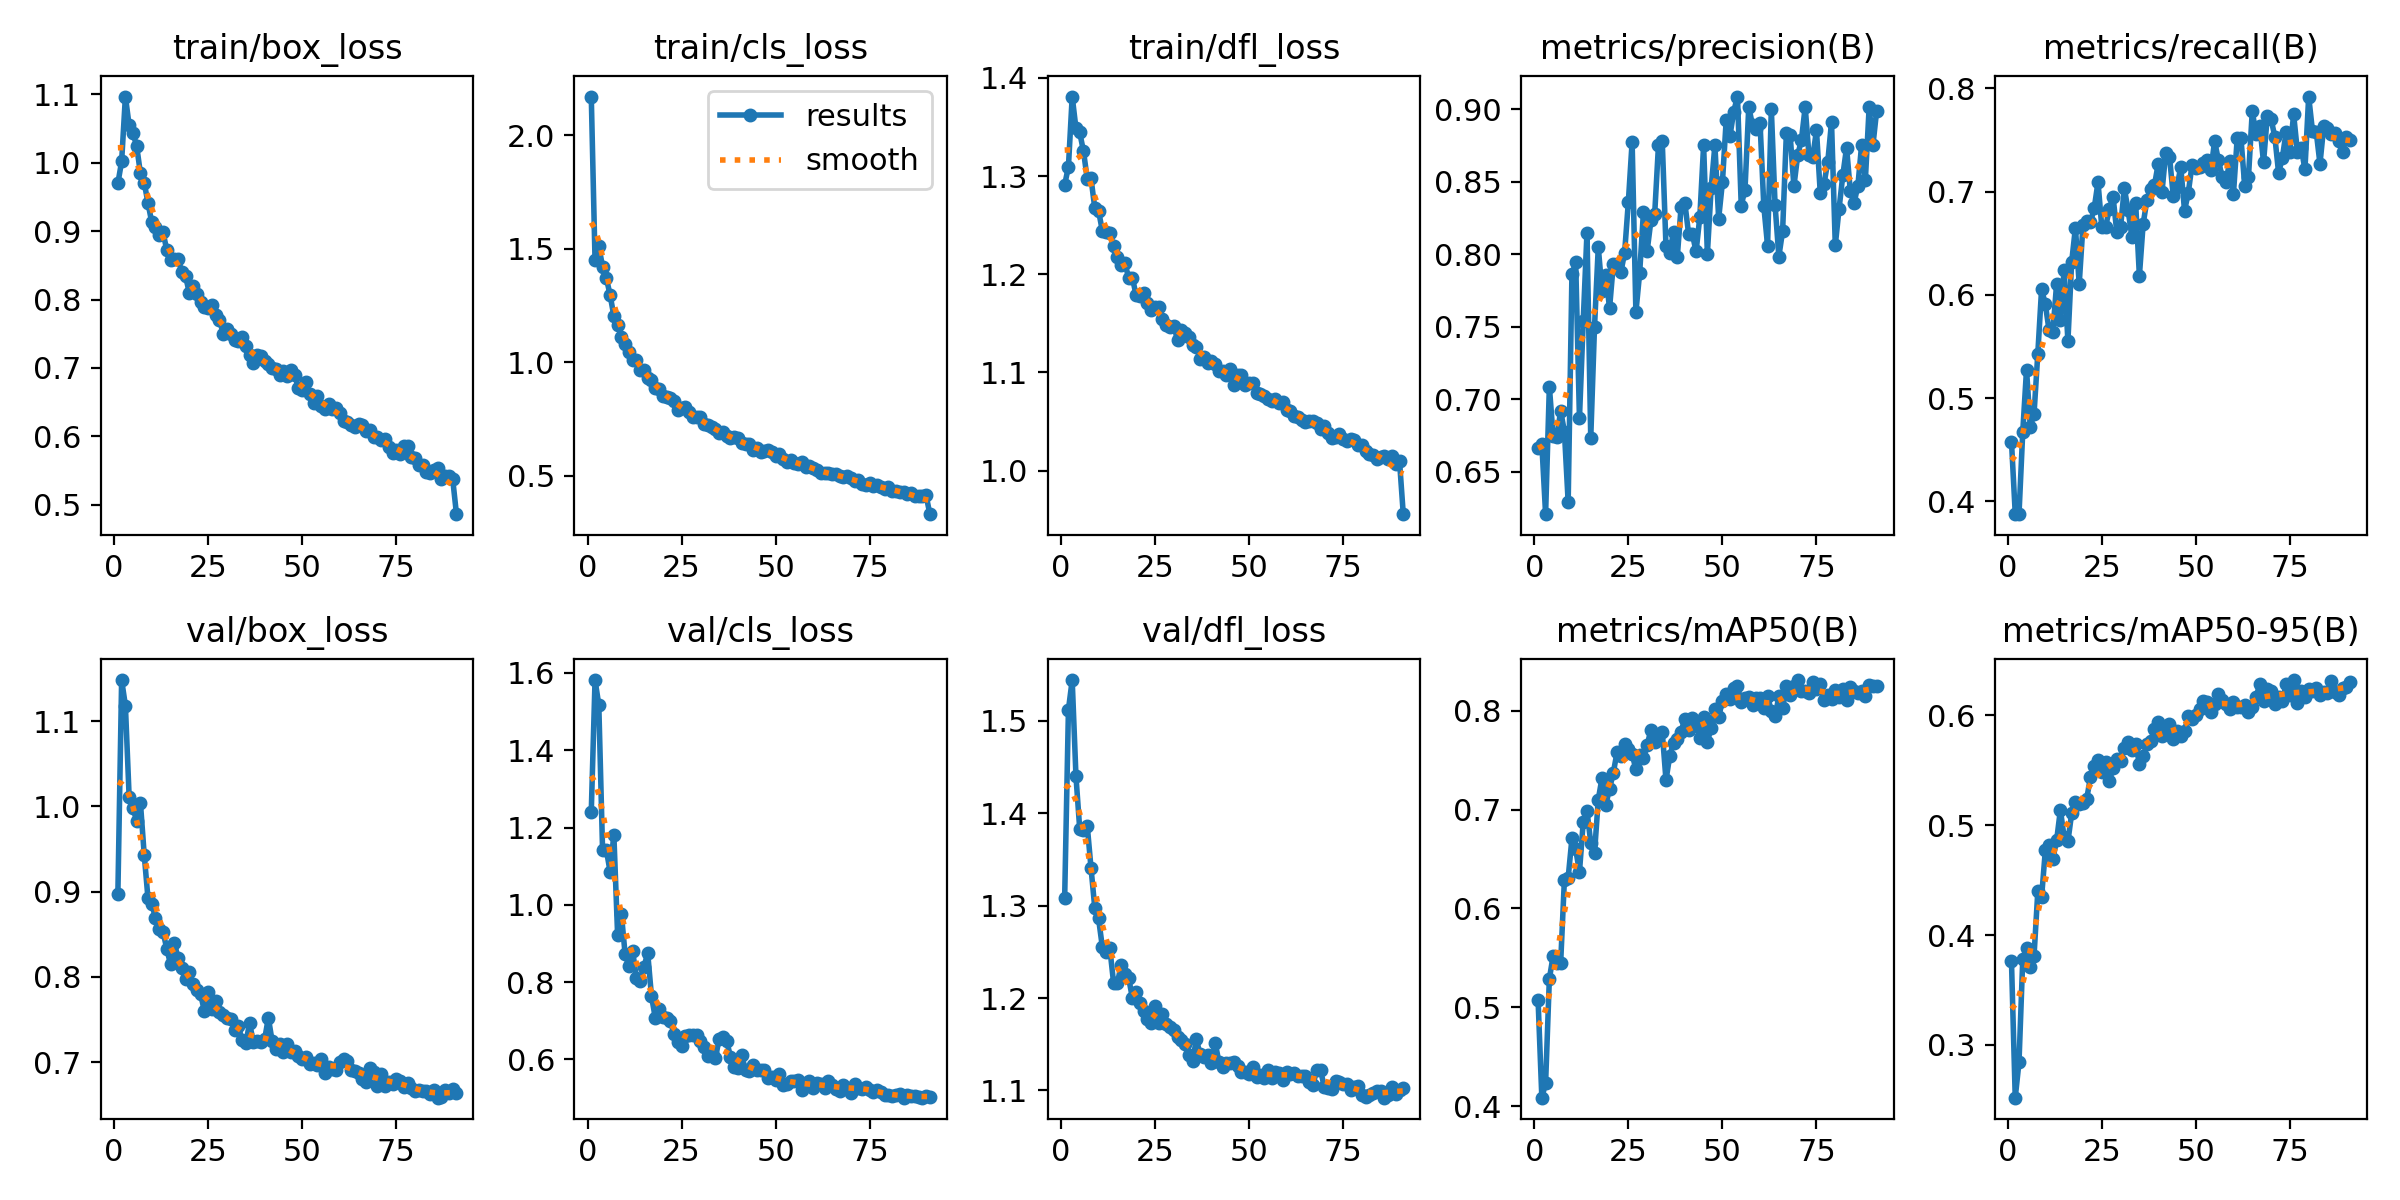


📊 Confusion Matrix:


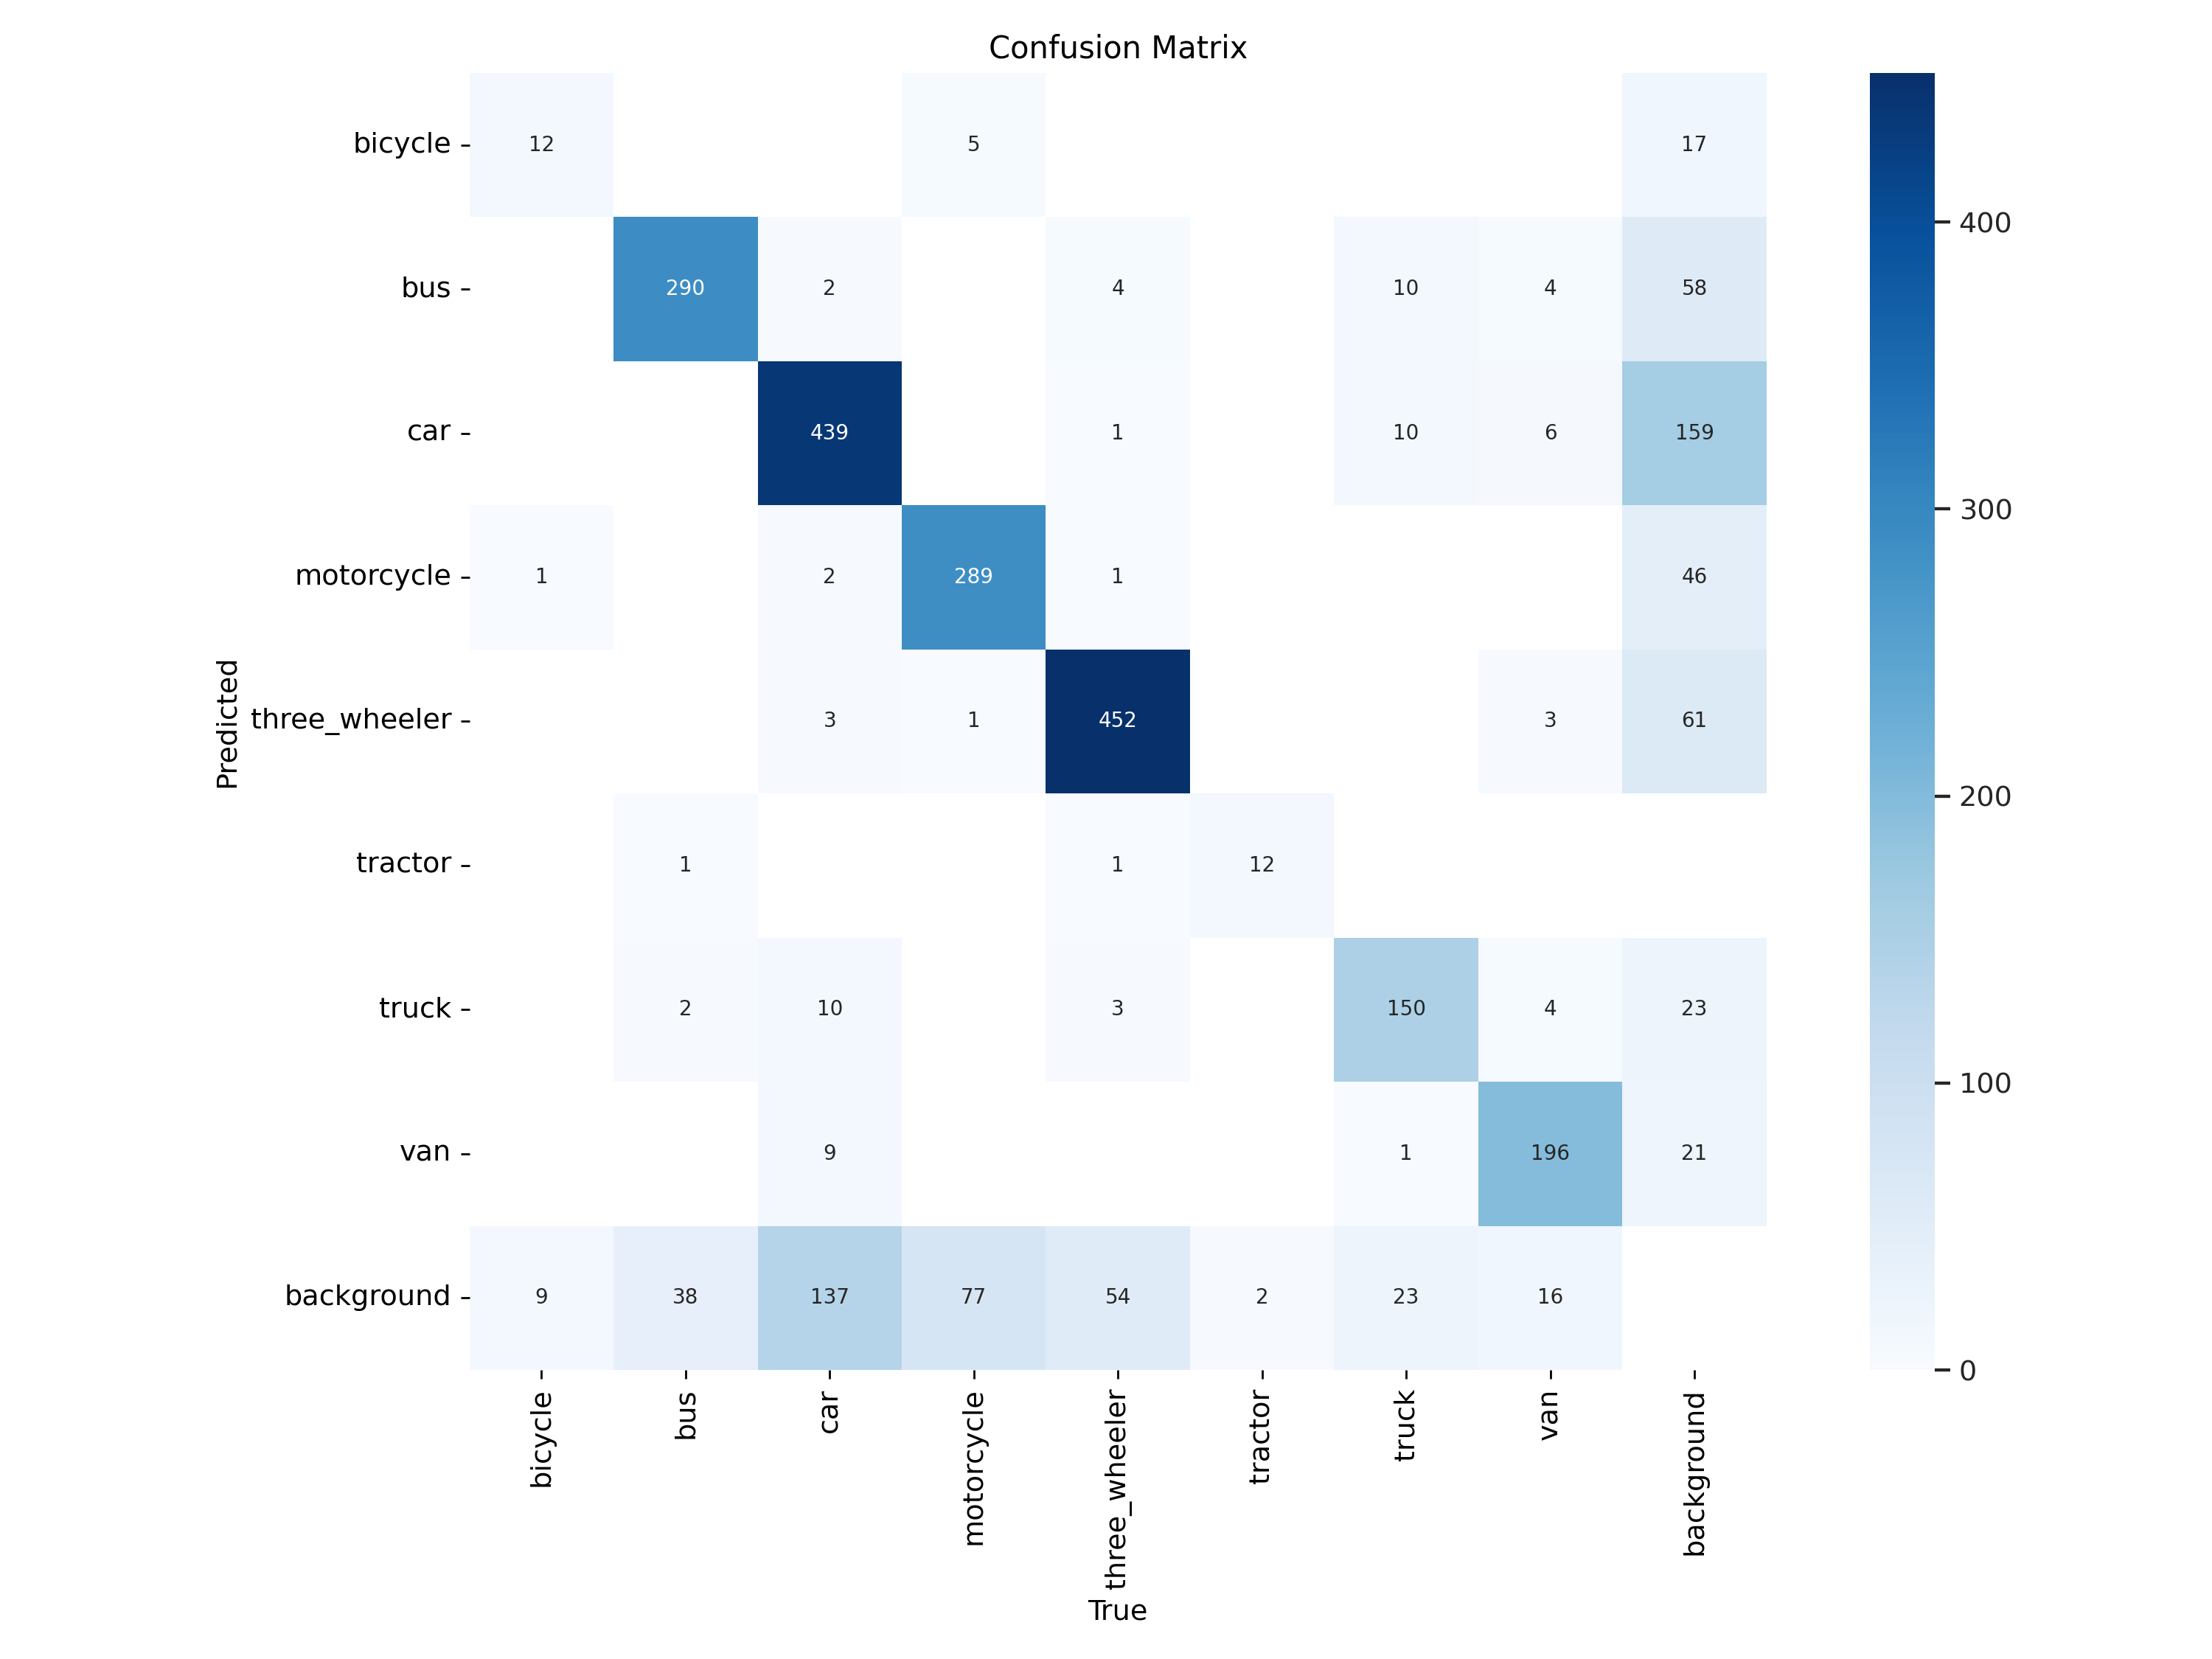


📊 F1 Curve:


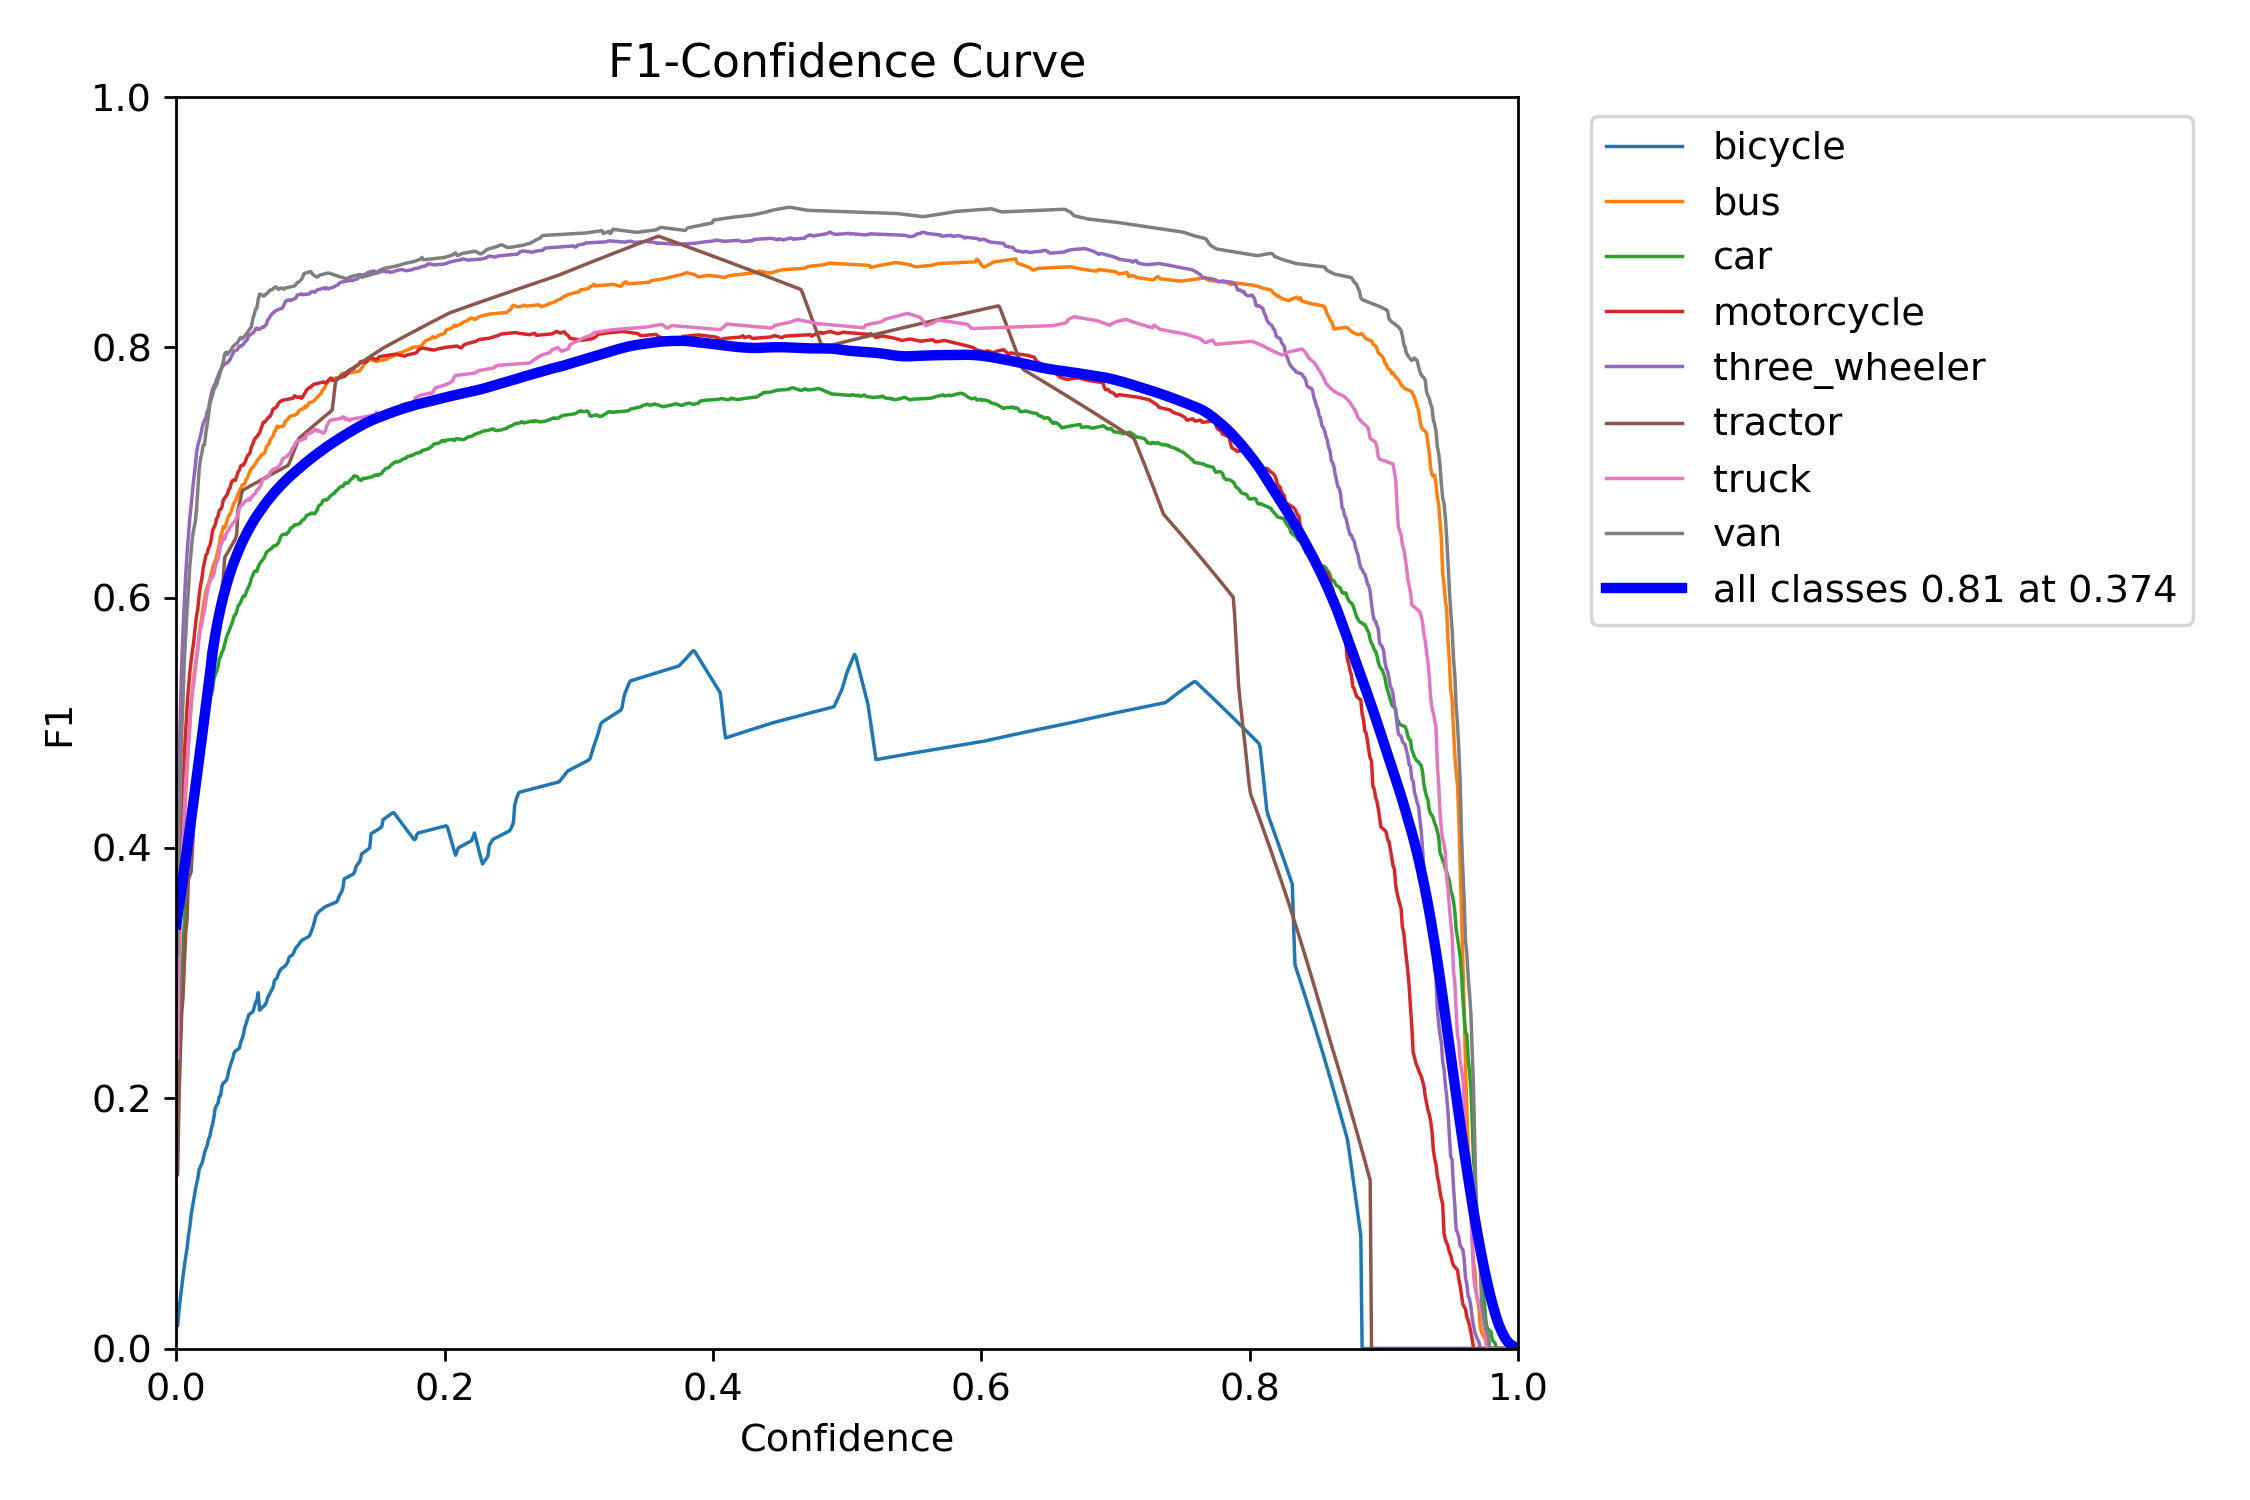


📊 Precision-Recall Curve:


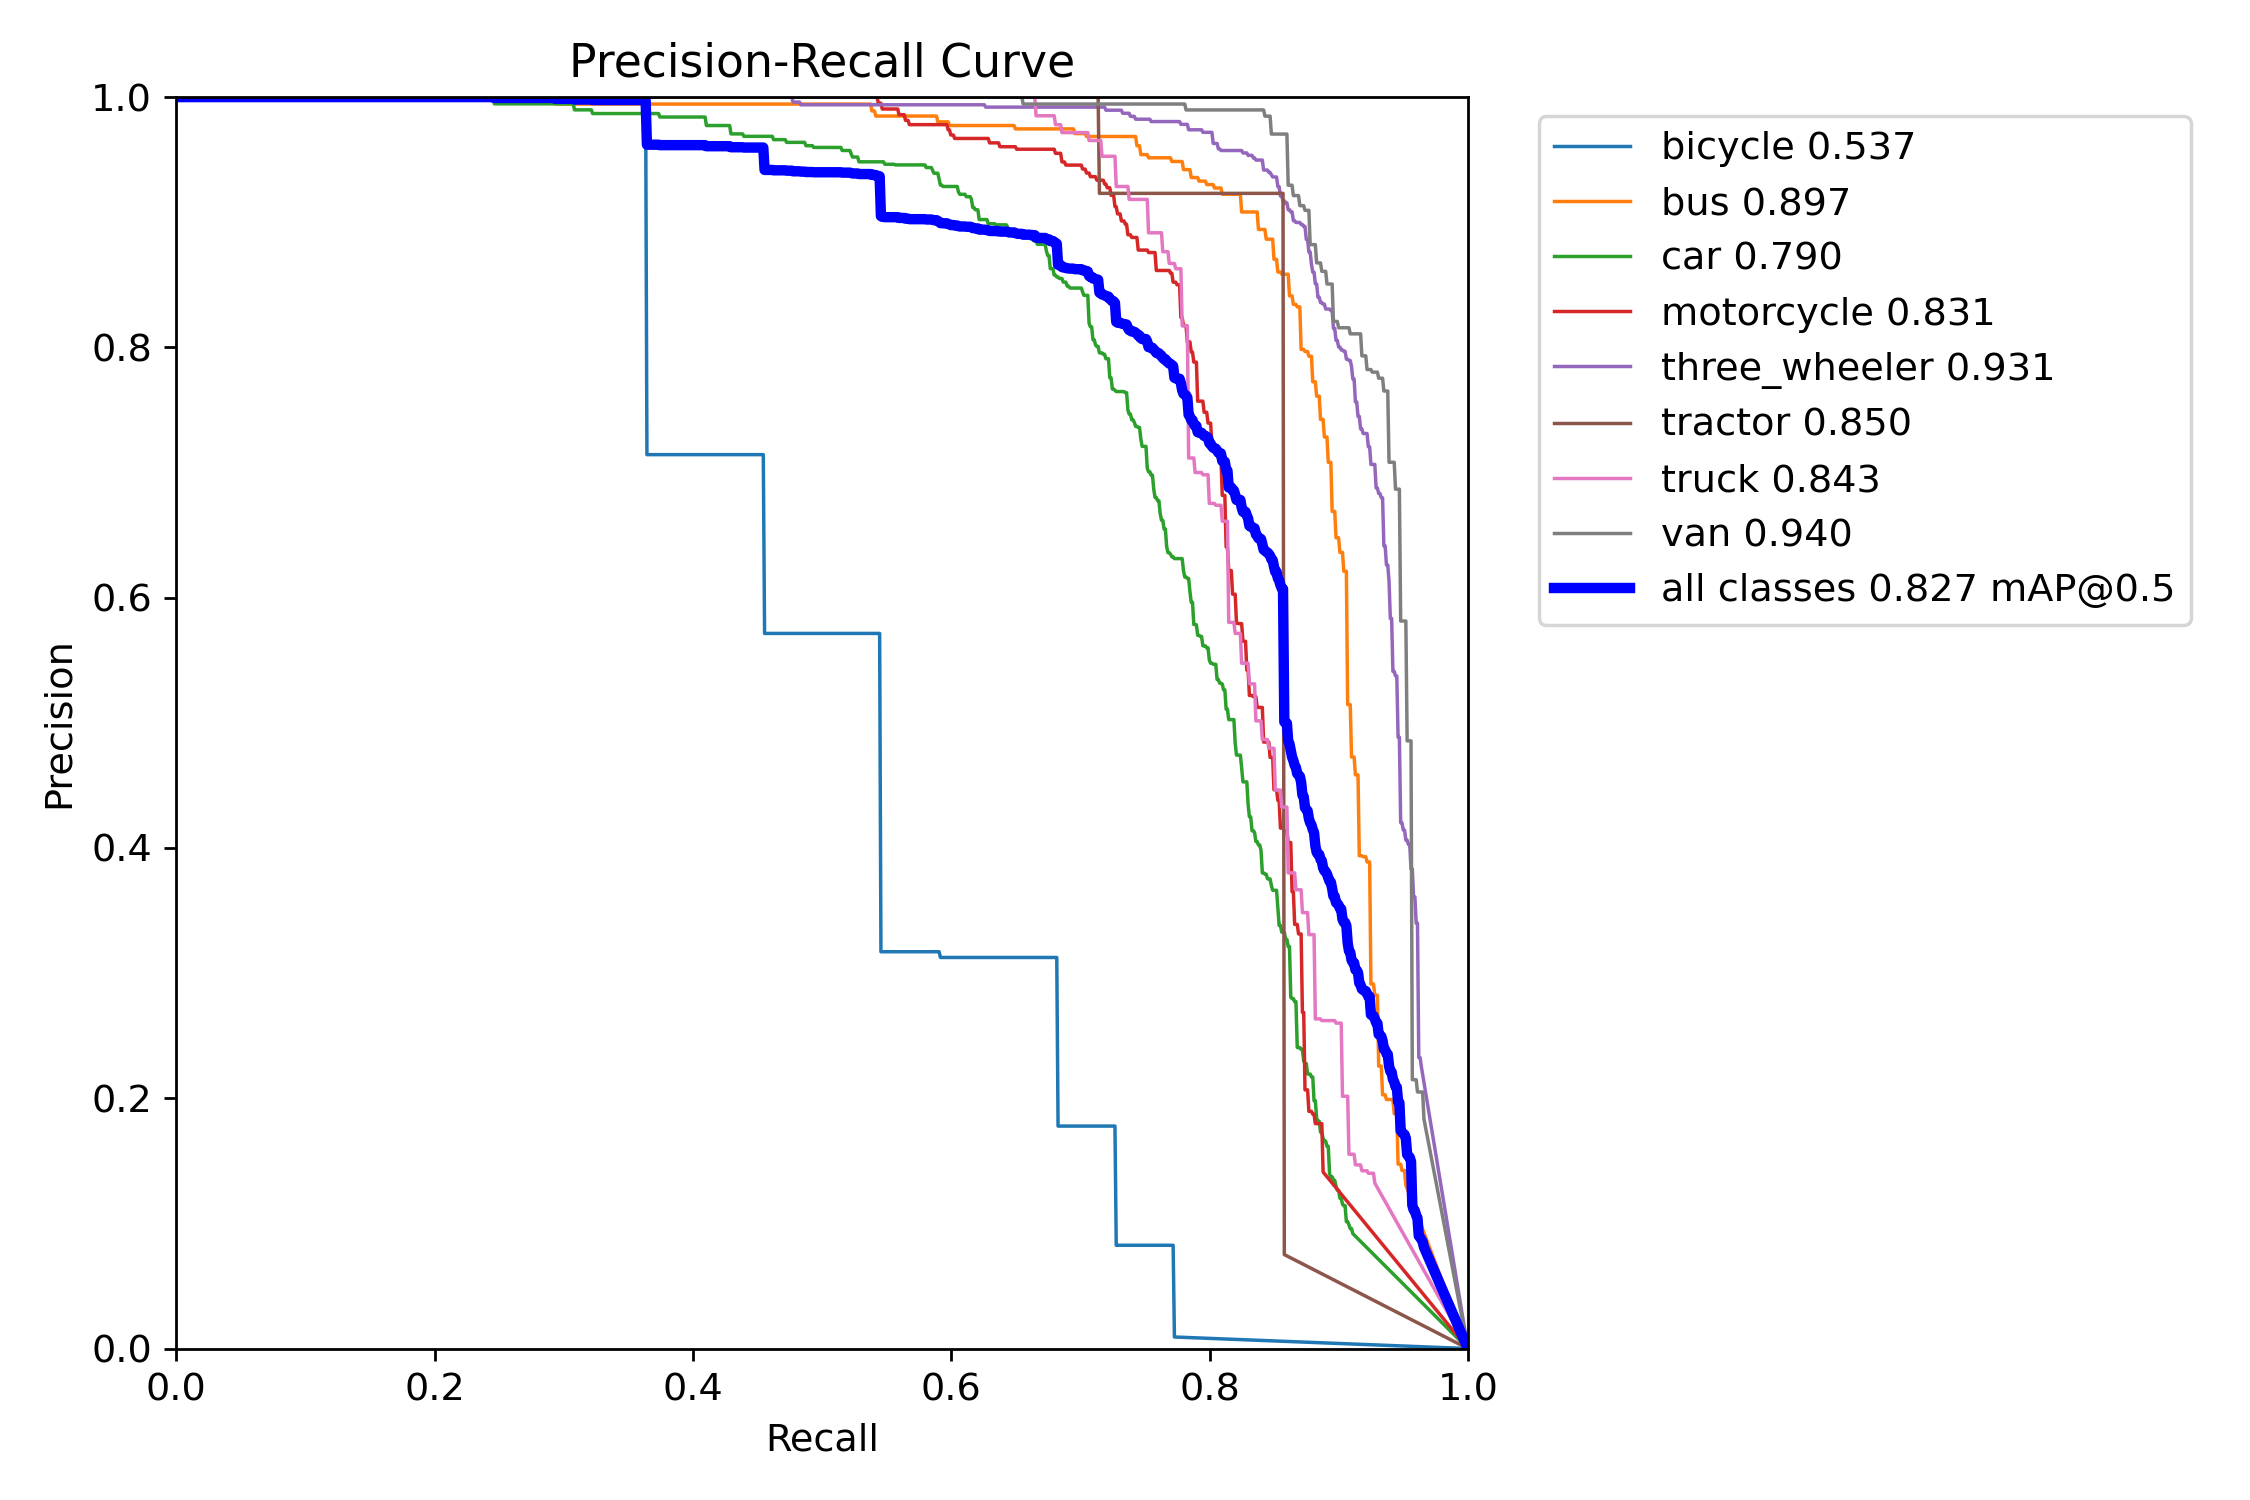

In [ ]:
from IPython.display import Image, display

results_dir = f"{PROJECT}/{NAME}"

print("=" * 60)
print("TRAINING VISUALIZATIONS")
print("=" * 60)

# Training curves
results_img = f"{results_dir}/results.png"
if os.path.exists(results_img):
    print("\n📊 Training Curves:")
    display(Image(filename=results_img, width=800))

# Confusion matrix
confusion_img = f"{results_dir}/confusion_matrix.png"
if os.path.exists(confusion_img):
    print("\n📊 Confusion Matrix:")
    display(Image(filename=confusion_img, width=700))

# F1 curve
f1_img = f"{results_dir}/F1_curve.png"
if os.path.exists(f1_img):
    print("\n📊 F1 Curve:")
    display(Image(filename=f1_img, width=700))

# PR curve
pr_img = f"{results_dir}/PR_curve.png"
if os.path.exists(pr_img):
    print("\n📊 Precision-Recall Curve:")
    display(Image(filename=pr_img, width=700))

Upload a test image to see detection:



image 1/1 /content/detected_istockphoto-155287967-612x612.jpg: 448x640 12 cars, 1 truck, 47.5ms
Speed: 4.9ms preprocess, 47.5ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to test_results/prediction


Saving detected_istockphoto-155287967-612x612.jpg to detected_istockphoto-155287967-612x612.jpg

✅ Detection complete!


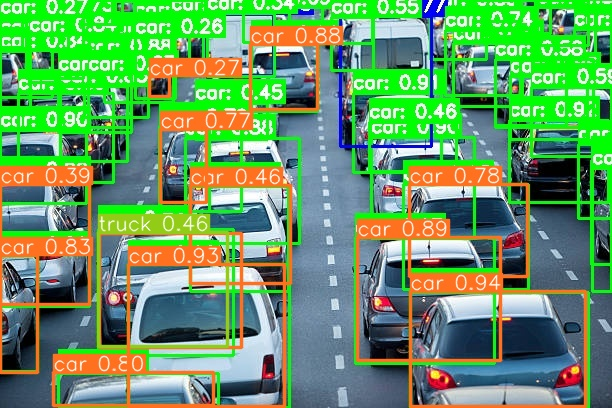


Found 13 vehicles:
  1. car: 94.29%
  2. car: 93.25%
  3. car: 88.58%
  4. car: 88.26%
  5. car: 83.01%
  6. car: 79.64%
  7. car: 77.77%
  8. car: 77.21%
  9. truck: 46.29%
  10. car: 45.89%
  11. car: 39.40%
  12. car: 32.65%
  13. car: 26.69%


In [ ]:
print("Upload a test image to see detection:")
test_img = files.upload()

if test_img:
    img_name = list(test_img.keys())[0]

    # Predict
    results = model.predict(
        source=img_name,
        conf=0.25,
        save=True,
        project='test_results',
        name='prediction'
    )

    # Show result
    result_img = f"test_results/prediction/{img_name}"
    if os.path.exists(result_img):
        print("\n✅ Detection complete!")
        display(Image(filename=result_img, width=800))

        # Show detections
        boxes = results[0].boxes
        if len(boxes) > 0:
            print(f"\nFound {len(boxes)} vehicles:")
            for i, box in enumerate(boxes):
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                cls_name = CLASSES[cls_id]
                print(f"  {i+1}. {cls_name}: {conf:.2%}")
        else:
            print("\nNo vehicles detected")

In [ ]:
print("Preparing model for download...")

# Zip the weights folder
model_weights = f"{PROJECT}/{NAME}/weights"
zip_name = "trained_model"

shutil.make_archive(zip_name, 'zip', model_weights)

# Download
print(f"Downloading {zip_name}.zip...")
files.download(f'{zip_name}.zip')

print("\n✅ Download complete!")
print("\nModel files included:")
print("  - best.pt (best model)")
print("  - last.pt (last epoch)")


Preparing model for download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download complete!

Model files included:
  - best.pt (best model)
  - last.pt (last epoch)
